# CRF-based Named Entity Recognition

### Steve Neale - 2018

This notebook describes named entity recognition (NER) using conditional random fields or 'CRFs', which are very popular for this task. I've implemented the model using scikit-learn's 'sklearn-crfsuite' library.

In [1]:
import math
import warnings

import pyprind

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from sklearn.exceptions import UndefinedMetricWarning

from model_plots import plot_learning_curve

## Load the NER dataset into a Pandas DataFrame

First, the data is loaded into a Pandas DataFrame. This can be done easily using the `read_csv` function, specifying that the separator is a space. It's also useful to keep the blank lines, which are helpful later for determining the sentence breaks.

Once the data is loaded into a DataFrame, the easy access we have to columns allows a couple of useful things to be done - group the data by the "ne" column to see the distributions of each tag, and extract the classes (disregarding 'O' and blank lines with NaN values) as a list.

In [3]:
# Read the NER data using spaces as separators, keeping blank lines and adding columns
ner_data = pd.read_csv("./data/conll2003/train.txt", sep=" ", header=None, skip_blank_lines=False, encoding="utf-8")
ner_data.columns = ["token", "pos", "chunk", "ne"]

# Explore the distribution of NE tags in the dataset
tag_distribution = ner_data.groupby("ne").size().reset_index(name='counts')
print(tag_distribution)

       ne  counts
0   B-LOC    7140
1  B-MISC    3438
2   B-ORG    6321
3   B-PER    6600
4   I-LOC    1157
5  I-MISC    1155
6   I-ORG    3704
7   I-PER    4528
8       O  168346


In [4]:
# Extract the useful classes (not 'O' or NaN values) as a list
classes = list(filter(lambda x: x not in ["O", np.nan], list(ner_data["ne"].unique())))

print(classes)

['B-ORG', 'B-MISC', 'B-PER', 'I-PER', 'B-LOC', 'I-ORG', 'I-MISC', 'I-LOC']


## Extract sentences from the dataset

Next, sentences need to be extracted from the data - it's useful to have the sentences as a list of lists, with each sublist containing the token, POS tag, syntactic chunk, and NE label for every word token in the sentence.

In [5]:
# Create a sentences dictionary and an initial single sentence dictionary
sentences, sentence = [], []
# Create a progress bar
pbar = pyprind.ProgBar(len(ner_data))
# For each row in the NER data...
for index, row in ner_data.iterrows():
    # If the row is empty (no string in the token column)
    if type(row["token"]) != str:
        # If the current sentence is not empty, append it to the sentences and create a new sentence
        if len(sentence) > 0:
            sentences.append(sentence)
            sentence = []
    # Otherwise...
    else:
        # If the row does not indicate the start of a document, add the token to the current sentence
        if type(row["token"]) != float and type(row["pos"]) != float and type(row["ne"]) != float:
            if not row["token"].startswith("-DOCSTART-"):
                sentence.append([row["token"], row["pos"], row["chunk"], row["ne"]])
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:24


## Extract sentence features

The 'sklearn-crfsuite' website provides a tutorial on their CRF model, which contains example code for extracting word features as a dictionary ready-formatted for use with the model. The function below is based on their model, making use of:

* Current words
* Previous words
* Next words
* Current POS tags
* Previous and next POS tags

These features are all used in the Stanford NLP group's work on using CRFs for NER (Finkel et al., 2005). They also make use of a 'current word shape' feature, which generally shows the upper-cased letters, lower-cased letters, and digits that make up a word (For example, 'CoNLL-2003' => 'XxXXX-dddd'). In the 'sclearn-crfsuite' implementation below, the 'word.isupper()', 'word.istitle()', and 'word.isdigit()' features are used in place of this.

The function below has also had a flag added to it to include chunk tags from the training data as features, for the current, previous, and next words.

In [6]:
def word_features(sentence, i, use_chunks=False):
    # Get the current word and POS
    word = sentence[i][0]
    pos = sentence[i][1]
    # Create a feature dictionary, based on characteristics of the current word and POS
    features = { "bias": 1.0,
                 "word.lower()": word.lower(),
                 "word[-3:]": word[-3:],
                 "word[-2:]": word[-2:],
                 "word.isupper()": word.isupper(),
                 "word.istitle()": word.istitle(),
                 "word.isdigit()": word.isdigit(),
                 "pos": pos,
                 "pos[:2]": pos[:2],
               }
    # If chunks are being used, add the current chunk to the feature dictionary
    if use_chunks:
        chunk = sentence[i][2]
        features.update({ "chunk": chunk })
    # If this is not the first word in the sentence...
    if i > 0:
        # Get the sentence's previous word and POS
        prev_word = sentence[i-1][0]
        prev_pos = sentence[i-1][1]
        # Add characteristics of the sentence's previous word and POS to the feature dictionary
        features.update({ "-1:word.lower()": prev_word.lower(),
                          "-1:word.istitle()": prev_word.istitle(),
                          "-1:word.isupper()": prev_word.isupper(),
                          "-1:pos": prev_pos,
                          "-1:pos[:2]": prev_pos[:2],
                        })
        # If chunks are being used, add the previous chunk to the feature dictionary
        if use_chunks:
            prev_chunk = sentence[i-1][2]
            features.update({ "-1:chunk": prev_chunk })
    # Otherwise, add 'BOS' (beginning of sentence) to the feature dictionary
    else:
        features["BOS"] = True
    # If this is not the last word in the sentence...
    if i < len(sentence)-1:
        # Get the sentence's next word and POS
        next_word = sentence[i+1][0]
        next_pos = sentence[i+1][1]
        # Add characteristics of the sentence's previous next and POS to the feature dictionary
        features.update({ "+1:word.lower()": next_word.lower(),
                          "+1:word.istitle()": next_word.istitle(),
                          "+1:word.isupper()": next_word.isupper(),
                          "+1:pos": next_pos,
                          "+1:pos[:2]": next_pos[:2],
                        })
        # If chunks are being used, add the next chunk to the feature dictionary
        if use_chunks:
            next_chunk = sentence[i+1][2]
            features.update({ "+1:chunk": next_chunk })
    # Otherwise, add 'EOS' (end of sentence) to the feature dictionary
    else:
        features["EOS"] = True
    # Return the feature dictionary
    return features

Using the word_features function, a list of feature dictionaries for each word token in a sentence can be extracted, corresponding to a list of NE labels for each word token in a sentence.

In [7]:
# Return a feature dictionary for each word in a given sentence
def sentence_features(sentence, use_chunks=False):
    return [word_features(sentence, i, use_chunks) for i in range(len(sentence))]

# Return the label (NER tag) for each word in a given sentence
def sentence_labels(sentence):
    return [label for token, pos, chunk, label in sentence]

## Split the sentences into training and test sets

Using the predefined functions, X and y can be extracted as lists of feature dictionaries for each word token in each sentence, and as lists of NE labels for each word token in each sentence, respectively. scikit-learn's 'test_train_split' function can then be used to split X and y into training and test sets, split 80% training to 20% test.

In [8]:
# For each sentence, extract the sentence features as X, and the labels as y
X = [sentence_features(sentence) for sentence in sentences]
y = [sentence_labels(sentence) for sentence in sentences]

# Split X and y into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("First token features:\n{}\n{}".format("-"*21, X_train[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_train[0][0]))

First token features:
---------------------
{'+1:word.lower()': 'entire', '+1:word.istitle()': False, 'word.lower()': 'the', 'pos': 'DT', 'word[-3:]': 'The', 'BOS': True, 'word.isupper()': False, 'word.istitle()': True, 'bias': 1.0, '+1:pos': 'JJ', '+1:word.isupper()': False, 'word[-2:]': 'he', '+1:pos[:2]': 'JJ', 'word.isdigit()': False, 'pos[:2]': 'DT'}

First token label:
------------------
O


## Train a CRF model

The training data can now be used to train a CRF (conditional random fields) model to map the feature dictionaries to output NE labels. CRF's have been a popular choice for training named entity recognition models following the success of the Stanford NLP group's work on NER (Finkel et al., 2005). The model employs the gradient descent-based L-BFGS algorithm, and uses elastic net (C1+C2) regularisation.

In [9]:
# Create a new CRF model
crf = CRF(algorithm="lbfgs",
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)

# Train the CRF model on the supplied training data
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

## Evalute the CRF model

The trained model can now be used to make predictions based on the test data, which can in turn be compared to the expected labels from the test data to produce a classification report (precision, recall and F1 scores).

The model is performing pretty well, with a 91% F1-score.

In [11]:
# Use the CRF model to make predictions on the test data
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

             precision    recall  f1-score   support

      B-ORG       0.91      0.88      0.90      1301
     B-MISC       0.95      0.87      0.91       697
      B-PER       0.92      0.92      0.92      1326
      I-PER       0.93      0.96      0.95       894
      B-LOC       0.93      0.93      0.93      1378
      I-ORG       0.87      0.87      0.87       789
     I-MISC       0.82      0.79      0.80       240
      I-LOC       0.86      0.82      0.84       238

avg / total       0.91      0.90      0.91      6863



## Optimise the model's parameters

It's useful to see if we can improve performance at all by tuning some of the model's parameters. In this case, we can experiment with different parameters for the C1 and C2 values used for the elastic net regularisation.

To do this, we can employ a cross-validated randomised search - an exhaustive grid search of all parameter combinations can also be done using scikit-learn, but this can get really computationally intensive. By limiting the randomised search to 50 iterations (random parameter combinations) and using 3-fold cross validation, we are essentially fitting 150 models, which is already quite intensive.

Following the optimisation, we can see that lower values (increased regularisation strength) for both C1 and C2 values result in the best performing model - particularly for C1.

In [12]:
# Set up a parameter grid to experiment with different values for C1 and C2
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = {"c1": param_range,
              "c2": param_range}

# Set up a bespoke scorer that will compare the cross validated models according to their F1 scores
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=classes)

# Perform a 3-fold cross-validated, randomised search of 50 combinations for different values for C1 and C2
rs = RandomizedSearchCV(estimator=crf,
                        param_distributions=param_grid,
                        scoring=f1_scorer,
                        cv=3,
                        verbose=1,
                        n_iter=50,
                        n_jobs=-1)

# Train the models in the randomised search, ignoring any 'UndefinedMetricWarning' that comes up 
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    rs.fit(X_train, y_train)

# Print the model that scored highest in the randomised search, and the parameters it used
print(rs.best_score_)
print(rs.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.9min finished


0.9007364726210794
{'c1': 0.001, 'c2': 0.01}


## Evaluate the optimised CRF model on the test data

Now, the optimised model can be used to make predictions based on the test data, which can in turn be compared to the expected labels from the test data to produce a classification report (precision, recall and F1 scores)

The optimised model is performing slightly better, with precision, recall, and F1-score all having improved slightly.

In [13]:
# Replace the CRF model with the best model from the randomised search
crf = rs.best_estimator_

y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

             precision    recall  f1-score   support

      B-ORG       0.92      0.89      0.90      1301
     B-MISC       0.95      0.89      0.91       697
      B-PER       0.94      0.93      0.94      1326
      I-PER       0.95      0.96      0.95       894
      B-LOC       0.93      0.95      0.94      1378
      I-ORG       0.89      0.88      0.88       789
     I-MISC       0.84      0.80      0.82       240
      I-LOC       0.87      0.83      0.85       238

avg / total       0.92      0.91      0.92      6863



## Create new training and test data using chunks as features

Seeing as there are syntactic chunks included in our dataset, let's see if they make a difference when included as additional features in the training data. As before, the predefined functions can be used to extract X and y - lists of feature dictionaries for each word token in each sentence, and lists of NE labels for each word token in each sentence, respectively. This time, however, the 'use_chunks' flag has been set when extracting X.

scikit-learn's 'test_train_split' function is again used to split X and y into training and test sets, split 80% training to 20% test.

In [14]:
# For each sentence, extract the sentence features as X, and the labels as y
X = [sentence_features(sentence, use_chunks=True) for sentence in sentences]
y = [sentence_labels(sentence) for sentence in sentences]

# Split X and y into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("First token features:\n{}\n{}".format("-"*21, X_train[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_train[0][0]))

First token features:
---------------------
{'chunk': 'B-NP', 'word.lower()': 'the', 'word[-3:]': 'The', 'bias': 1.0, '+1:pos': 'JJ', 'word[-2:]': 'he', '+1:pos[:2]': 'JJ', 'word.isdigit()': False, '+1:chunk': 'I-NP', '+1:word.istitle()': False, '+1:word.lower()': 'entire', '+1:word.isupper()': False, 'pos': 'DT', 'BOS': True, 'word.isupper()': False, 'word.istitle()': True, 'pos[:2]': 'DT'}

First token label:
------------------
O


## Train and evalute the optimised model using the w/chunks dataset

After training the optimised model on the training data that includes the chunks, predictions are made based on the test data, and then used to produce a classification report (precision, recall and F1 scores) by comparing it with the labels from the test data.

The optimised model trained on the test data performs slightly better again, with precision now having risen to 93%.

In [15]:
# Retrain the CRF model on the new training data
crf.fit(X_train, y_train)

# Use the CRF model to make predictions on the test data
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

             precision    recall  f1-score   support

      B-ORG       0.92      0.89      0.91      1301
     B-MISC       0.95      0.88      0.91       697
      B-PER       0.94      0.94      0.94      1326
      I-PER       0.95      0.97      0.96       894
      B-LOC       0.93      0.94      0.94      1378
      I-ORG       0.89      0.88      0.88       789
     I-MISC       0.82      0.80      0.81       240
      I-LOC       0.88      0.83      0.86       238

avg / total       0.93      0.91      0.92      6863



## Plot learning curves for the optimised model (w/chunks dataset)

The performance of the model can be evaluated using a learning curve, plotting the accuracy of predictions on the training and test datasets as more training data is fed to the model. As we'd expect, the accuracy on the test data increases with the number of training samples.

[learning_curve] Training set sizes: [ 748 1497 2246 2995 3744 4492 5241 5990 6739 7488]


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


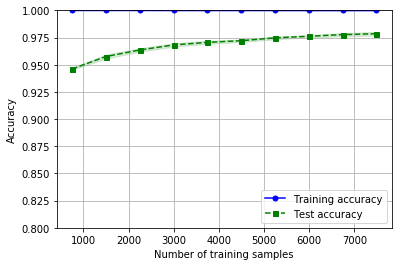

In [16]:
# Produce the necessary data for a learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=crf,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=3,
                                                        verbose=1,
                                                        n_jobs=-1)

# Find the means and standard deviations of the training and test datasets across the learning curve
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std)

There is still a bit of a gap between the test and training accuracy, suggesting that the model is perhaps a little overfit to the training data. More training data, or experimentation with new/different feature combinations might negate this going forwards. Features that could be added or experimented with might include:

* Character n-grams (used for current words by Finkel et al. (2005))
* True word shapes (current implementation only returns whether the whole word is made of upper-cased letters of digits, or if the word starts with a capital letter, but doesn't flag words that combine upper/lower-cased letter and digits)
* Presence of the current word in a left or right window of given size (used by Finkel et al. (2005))
* The value of the current word bias (currently left at 1.0 for every word)

# References

Finkel, J.R., Grenager, T. & Manning, C. (2005). 'Incorporating Non-local Information into Information Extraction Systems by Gibbs Sampling'. In Proceedings of the 43rd Annual Meeting of the Association for Computational Linguistics (ACL '05). pp. 363–370.

sklearn-crfsuite (n.d.). 'Tutorial - scklearn-crfsuite 0.3 documentation' [https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html#features]. Accessed 2018-11-30.